# Seguimiento con DINOv3 (Cuaderno educativo)

Este cuaderno guía a estudiantes en visión por computador para entender cómo extraer características densas con DINOv3, crear una representación promedio de un objeto a partir de ejemplos enmascarados y utilizarla para segmentar frames de vídeo.

Objetivos:
- Cargar un modelo DINOv3 y extraer características densas.
- Construir una 'patch average' a partir de parches enmascarados.
- Visualizar resultados y guardar vídeos de segmentación.

In [14]:
# Importaciones y constantes
import pickle
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from scipy import signal
from glob import glob
from torch import Tensor
import matplotlib.cm as cm
from transformers import AutoModel, DINOv3ViTModel
import numpy as np
from tqdm import tqdm

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
PATCH_SIZE = 16
IMAGE_SIZE = 960

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Funciones auxiliares
Definimos las funciones para redimensionar, extraer características densas y visualizar resultados.

In [2]:
def resize_transform(mask_image: Image) -> torch.Tensor:
    return TF.to_tensor(TF.resize(mask_image, (IMAGE_SIZE, IMAGE_SIZE)))

def extract_dense_features(image, normalize: bool = True) -> Tensor:
    """Extrae características densas utilizando el modelo DINOv3 cargado en la variable `model`.
    Devuelve un tensor [C, H_patches, W_patches] en CPU."""
    with torch.inference_mode():
        # Si hay GPU, usamos autocast para eficiencia
        with torch.autocast(device_type=('cuda' if device == 'cuda' else 'cpu'), dtype=torch.float32):
            image = image.convert("RGB")
            image_resized = resize_transform(image)
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_resized = image_resized.unsqueeze(0).to(device)
            outputs = model(image_resized, output_hidden_states=True)
            feats = outputs.last_hidden_state[:, 1 + model.config.num_register_tokens :, :]
            B, _, h, w = image_resized.shape
            feats = [
                out.reshape(
                    B, h // model.config.patch_size, w // model.config.patch_size, -1
                ).permute(0, 3, 1, 2).contiguous()
                for out in feats
            ]
            if normalize:
                feats = [F.normalize(f, p=2, dim=1) for f in feats]
            return feats[-1].squeeze().detach().cpu()

def compute_similarity(features_a: Tensor, features_b: Tensor) -> Tensor:
    """Producto punto entre dos mapas de características.
    features_a: [H1, W1, D], features_b: [H2, W2, D] -> salida [H1, W1, H2, W2]"""
    dot = torch.einsum("ijd, kld -> ijkl", features_a, features_b)
    return dot

def get_seg(frame, current_pred_np):
    segmented_frame = frame.copy()
    original_width, original_height = frame.size
    current_pred_np = Image.fromarray((current_pred_np).astype(np.uint8)).resize((original_width, original_height), resample=Image.NEAREST)
    current_pred_np = np.array(current_pred_np)

    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    opened = cv2.morphologyEx(current_pred_np, cv2.MORPH_OPEN, kernel)
    current_pred_np = opened
    segmented_frame += current_pred_np[:, :, None] * np.array([0, 50, 0], dtype=np.uint8)
    return segmented_frame

def jet_plot(frame, sims):
    colormap = cm.get_cmap("jet")
    original_width, original_height = frame.size
    colored_sims = colormap(sims.cpu().numpy())[:, :, :3]
    colored_sims = (colored_sims * 255).astype(np.uint8)
    colored_sims_pil = Image.fromarray(colored_sims).resize((original_width, original_height), resample=Image.NEAREST)
    blended = Image.blend(frame.convert("RGBA"), colored_sims_pil.convert("RGBA"), alpha=0.5)
    return blended

def pipeline(frame, average_patch):
    next_frame_features = extract_dense_features(frame)
    _next_frame_features = F.normalize(next_frame_features.permute(1, 2, 0), p=2, dim=-1)
    _context_features = F.normalize(average_patch, p=2, dim=0)
    final_sims = torch.einsum("ijk, k -> ij", _next_frame_features, _context_features)
    mask = (final_sims > 0.5).float().numpy()
    segmented_frame = get_seg(frame, mask)
    return segmented_frame

def new_jet_pipeline(frame, average_patch):
    next_frame_features = extract_dense_features(frame)
    _next_frame_features = F.normalize(next_frame_features.permute(1, 2, 0), p=2, dim=-1)
    _context_features = F.normalize(average_patch, p=2, dim=0)
    final_sims = torch.einsum("ijk, k -> ij", _next_frame_features, _context_features)
    segmented_frame = jet_plot(frame, final_sims)
    return segmented_frame

## Cargar el modelo DINOv3
Cargamos el modelo preentrenado. Esto puede tardar y requiere acceso a GPU para ser rápido.

In [3]:
dinov2 = False
model: DINOv3ViTModel = AutoModel.from_pretrained(
    ("dinov3-vitl16-pretrain-lvd1689m_offline"),
)
model.to(device)
print('Modelo cargado en', device)

Modelo cargado en cuda


## Cargar imágenes de ejemplo
Asegúrate de tener las carpetas `pasta_images/`, `pasta_masks/` y `extracted_frames/` junto a este cuaderno.

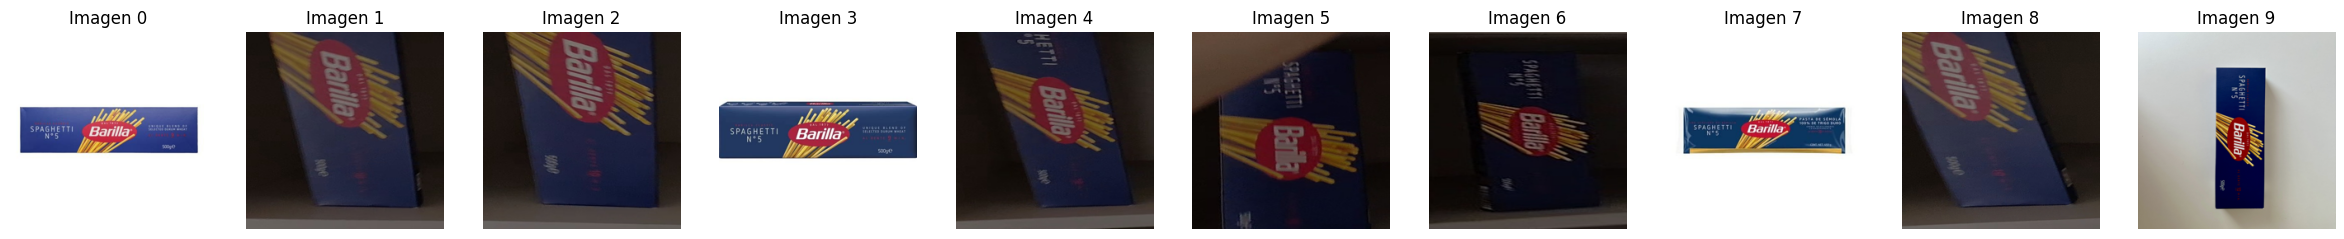

In [8]:
sample_frames = glob('pasta_images/*.jpg') + glob('pasta_images/*.png')
sample_frames = [Image.open(f).convert('RGB') for f in sample_frames]
show_frames = [frame.resize((240, 240)) for frame in sample_frames]
plt.figure(figsize=(30, 10))
for i, frame in enumerate(show_frames):
    plt.subplot(1, len(show_frames), i + 1)
    plt.imshow(frame)
    plt.title(f"Imagen {i}")
    plt.axis("off")

## Crear ejemplos de parches y máscaras
Extraemos características de los primeros 10 ejemplos y sus máscaras correspondientes.

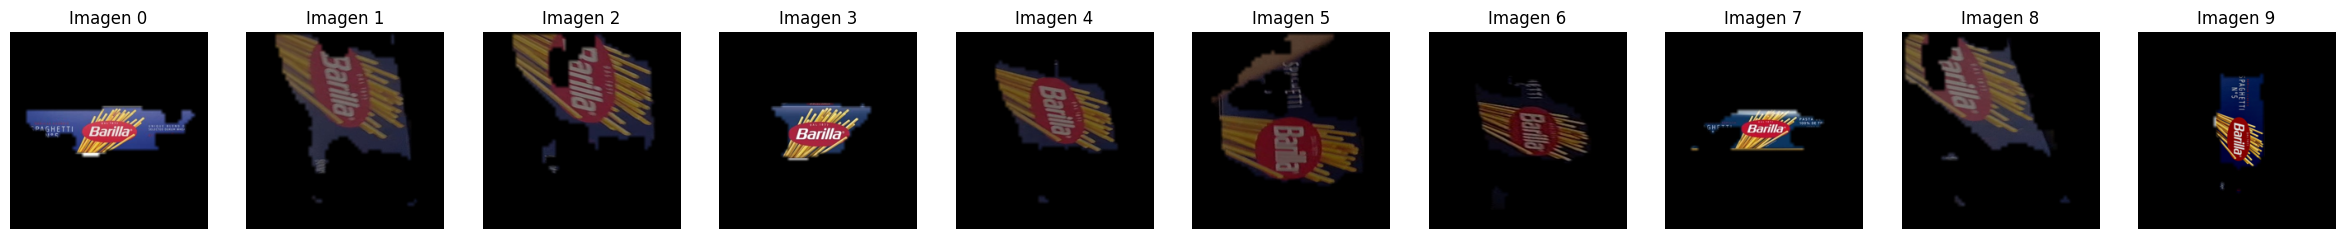

In [9]:
example_patches = []
example_masks = []
masked_images = []
for i in range(min(10, len(sample_frames))):
    image_features = extract_dense_features(sample_frames[i])
    example_patches.append(image_features)
    h_patches, w_patches = image_features.shape[1], image_features.shape[2]
    mask_path = f'pasta_masks/masked_image_{i}.jpg'
    if os.path.exists(mask_path):
        example_masks.append(
            TF.resize(
                TF.to_tensor(Image.open(mask_path)),
                (h_patches, w_patches),
            ).squeeze(0)
        )
        h, w = sample_frames[i].size
        masked_images.append(
            TF.to_pil_image(
                (
                    TF.to_tensor(sample_frames[i])
                    * TF.resize(example_masks[i].unsqueeze(0), (w, h))
                ).clamp(0, 1)
            )
        )
    else:
        print(f'No se encontró máscara: {mask_path}')

show_masked_images = [img.resize((240, 240)) for img in masked_images]
plt.figure(figsize=(30, 10))
for i, frame in enumerate(show_masked_images):
    plt.subplot(1, len(show_masked_images), i + 1)
    plt.imshow(frame)
    plt.title(f"Imagen {i}")
    plt.axis("off")

## Cargar frames del vídeo y calcular la representación promedio de parches
Construimos la `average_patch` usando los parches que corresponden a las máscaras.

In [11]:
frames = glob('extracted_frames/*.jpg')
frames.sort()
frames = [Image.open(f).convert('RGB') for f in frames]
num_frames = len(frames)
print(f'Número de frames: {num_frames}')
if num_frames>0:
    original_width, original_height = frames[0].size
    print(f'Tamaño original: ancho={original_width}, alto={original_height}')

if len(example_patches) > 0 and len(example_masks) > 0:
    flatt_patches = torch.stack(example_patches, dim=0).permute(0, 2, 3, 1).flatten(0, 2)
    average_patch = flatt_patches[torch.stack(example_masks, dim=0).flatten(0, 2).bool()].mean(dim=0)
    print('Average patch calculada')
else:
    average_patch = None
    print('No hay suficientes parches o máscaras para calcular average_patch')

Número de frames: 28
Tamaño original: ancho=720, alto=306
Average patch calculada


## Histograma de similitud de parches
Mostramos un histograma de la similitud coseno entre cada parche y la `average_patch`.

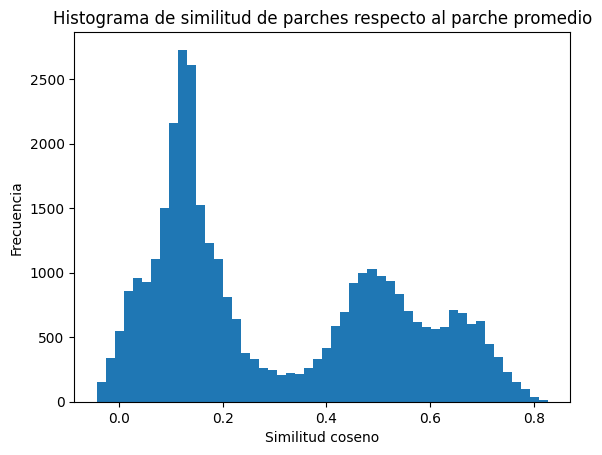

In [12]:
if average_patch is not None:
    patch_distance = F.cosine_similarity(flatt_patches, average_patch.unsqueeze(0), dim=1)
    plt.hist(patch_distance.cpu().numpy(), bins=50)
    plt.title('Histograma de similitud de parches respecto al parche promedio')
    plt.xlabel('Similitud coseno')
    plt.ylabel('Frecuencia')
    plt.show()
else:
    print('average_patch no disponible, salta el histograma')

## Segmentación de todos los frames y guardado de vídeo
Aplicamos la tubería de segmentación y guardamos dos vídeos: una segmentación binaria y una representación coloreada (jet).

100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Vídeo de segmentación binaria guardado


/tmp/ipykernel_3379191/149921985.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("jet")


Frame segmentado (mapa de calor)

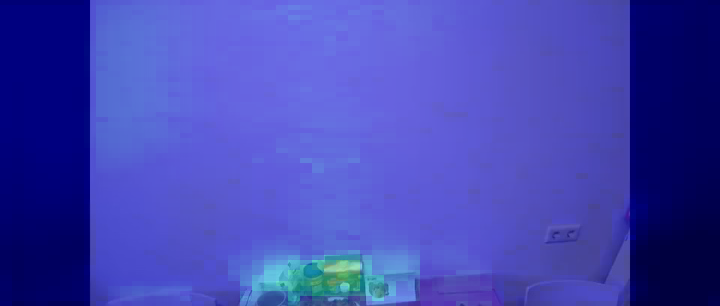

Frame segmentado (mapa de calor)

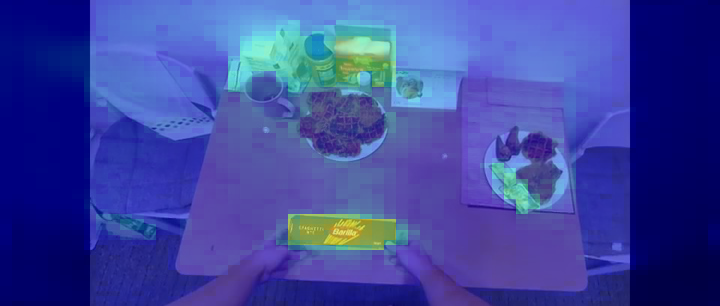

Frame segmentado (mapa de calor)

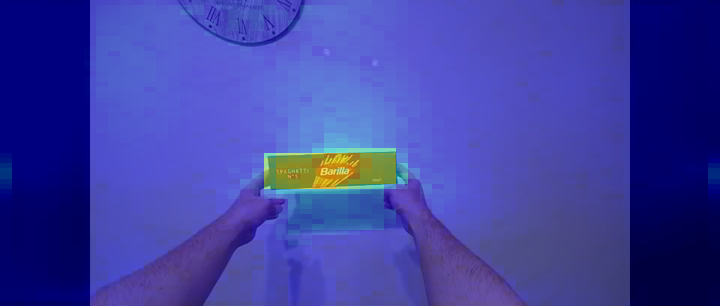

Frame segmentado (mapa de calor)

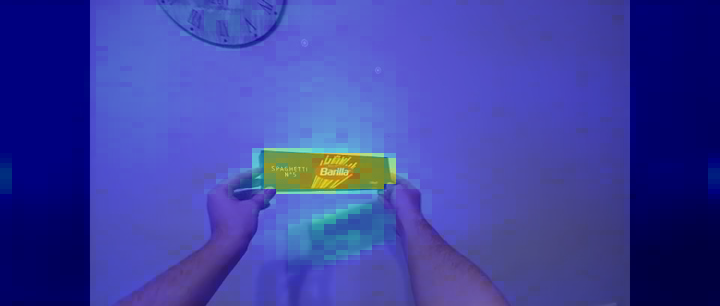

Frame segmentado (mapa de calor)

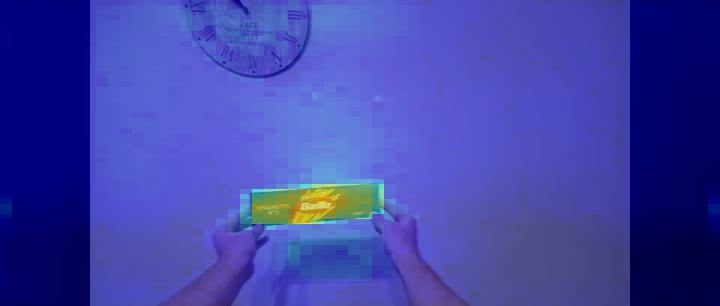

Frame segmentado (mapa de calor)

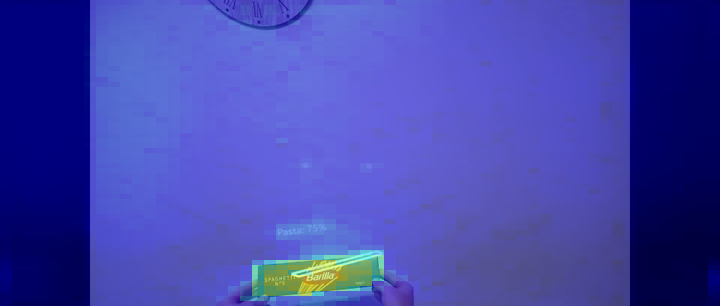

Frame segmentado (mapa de calor)

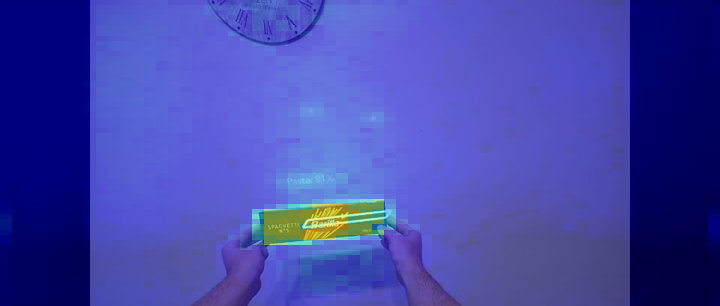

100%|██████████| 28/28 [00:12<00:00,  2.33it/s]

Vídeo de segmentación (jet) guardado


In [16]:
import mediapy as mp
if average_patch is not None and num_frames>0:
    video_name = 'dinov2_' if dinov2 else 'dinov3_'
    segmented_frames = []
    for frame in tqdm(frames):
        segmented_frame = pipeline(frame, average_patch)
        segmented_frames.append(segmented_frame)
    mp.write_video(f"{video_name}segmentacion.mp4", segmented_frames, fps=3)
    print('Vídeo de segmentación binaria guardado')

    # Mostrar algunos frames con mapa de calor (jet)
    for frame in frames[::max(1, num_frames//6)]:
        segmented_frame = new_jet_pipeline(frame, average_patch)
        mp.show_images([segmented_frame], titles=['Frame segmentado (mapa de calor)'], columns=1)

    segmented_frames = []
    for frame in tqdm(frames):
        segmented_frame = new_jet_pipeline(frame, average_patch)
        segmented_frames.append(np.asarray(segmented_frame)[:, :, :3])
    mp.write_video(f"{video_name}jet_segmentation.mp4", segmented_frames, fps=3)
    print('Vídeo de segmentación (jet) guardado')
else:
    print('No se pudo ejecutar la segmentación: faltan datos (average_patch o frames)')

Fin del cuaderno. Los estudiantes pueden experimentar cambiando umbrales, añadiendo post-procesado, o probando con otras máscaras de ejemplo.